# Christelle


In [26]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import os
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import tensorflow as tf
from sklearn.metrics import confusion_matrix

from tensorflow.keras.preprocessing.text import Tokenizer, one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense, Dropout, Flatten
from tensorflow.keras.layers import GlobalAveragePooling2D, MaxPooling2D, Conv2D

from imblearn.combine import SMOTETomek
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import ADASYN
from sklearn.utils.class_weight import compute_class_weight
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.layers import Reshape
from imblearn.over_sampling import SMOTE
from keras.layers import LSTM

In [27]:
import pandas as pd


malta_loc_18 = '../data/Malta-Budget-2018-dataset-v1.csv'
malta_loc_19 = '../data/Malta-Budget-2019-dataset-v1.csv'
malta_loc_20 = '../data/Malta-Budget-2020-dataset-v1.csv'

malta_data_18 = pd.read_csv(malta_loc_18)
malta_data_19 = pd.read_csv(malta_loc_19)
malta_data_20 = pd.read_csv(malta_loc_20)

print(malta_data_18.info())
print(malta_data_19.info())
print(malta_data_20.info())

malta_data_19 = malta_data_19.rename(columns={'Off-topic ':'Off-topic'})
combined_data = pd.concat([malta_data_18, malta_data_19, malta_data_20], ignore_index=True)
combined_data.info()

clean_data = combined_data.dropna(subset=['Online Post Text'])
clean_data = clean_data.drop(['Twitter ID', 'Related Online Post ID', 'Source ID','Off-topic'], axis=1)
clean_data = clean_data[clean_data['Language'] == 0] # get all data that is in english 
clean_data = clean_data.drop(['Language'], axis=1)
clean_data = clean_data.rename(columns={'Online Post ID':'ID','Online Post Text':'Text'})
clean_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2142 entries, 0 to 2141
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Online Post ID          2142 non-null   int64  
 1   Twitter ID              1673 non-null   float64
 2   Related Online Post ID  333 non-null    float64
 3   Source ID               2142 non-null   object 
 4   Online Post Text        469 non-null    object 
 5   Subjectivity            2142 non-null   int64  
 6   Sentiment Polarity      2142 non-null   object 
 7   Emotion                 2142 non-null   object 
 8   Sarcasm                 2142 non-null   int64  
 9   Irony                   2142 non-null   int64  
 10  Negation                2142 non-null   int64  
 11  Off-topic               2142 non-null   int64  
 12  Language                2142 non-null   int64  
dtypes: float64(2), int64(7), object(4)
memory usage: 217.7+ KB
None
<class 'pandas.core.frame.Dat

,ID,Text,Subjectivity,Sentiment Polarity,Emotion,Sarcasm,Irony,Negation
0,20180001,Great BUDGET . Even cigarettes were not touche...,1,positive,trust,0,0,1
1,20180002,I haven't exactly scanned the budget throughou...,1,negative,disgust,0,0,1
2,20180003,There’s already smoking cessation programs for...,1,neutral,anticipation,0,0,0
3,20180004,So should alcohol and fuel for private vehicle...,1,negative,sadness,0,0,0
4,20180005,Practical? You should say that in a third worl...,1,negative,anger,0,0,1


In [28]:
import string
import re
import nltk
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import contractions
from transformers import BertTokenizer

processed_data = clean_data.copy(deep=True)

def remove_special_characters(text):
    pattern = re.compile(r'[^a-zA-Z\s]')
    return pattern.sub('', text)

# Remove URLs and HTML tags
processed_data['Text'] = processed_data['Text'].str.replace(r'http\S+|www\S+|https\S+', '', regex=True)
processed_data['Text'] = processed_data['Text'].str.replace(r'<.*?>', '', regex=True)

# Expand contractions
processed_data['Text'] = processed_data['Text'].apply(lambda x: contractions.fix(x))

# Convert to lowercase
processed_data['Text'] = processed_data['Text'].str.lower()

# Remove punctuation
processed_data['Text'] = processed_data['Text'].str.replace(f"[{string.punctuation}]", " ", regex=True)

# Remove numbers
processed_data['Text'] = processed_data['Text'].str.replace(r'\d+', '', regex=True)

# Remove special characters
processed_data['Text'] = processed_data['Text'].apply(remove_special_characters)

# Remove stop words
stop_words = set(stopwords.words('english'))
processed_data['Text'] = processed_data['Text'].apply(lambda x: ' '.join(word for word in x.split() if word not in stop_words))

# Remove extra whitespace
processed_data['Text'] = processed_data['Text'].str.strip()
processed_data['Text'] = processed_data['Text'].str.replace(r'\s+', ' ', regex=True)

# Lemmatize
lemmatizer = WordNetLemmatizer()
processed_data['Text'] = processed_data['Text'].apply(lambda x: ' '.join(lemmatizer.lemmatize(word) for word in x.split()))

# Tokenize
# tokenizer = AutoTokenizer.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment") #96574
# tokenizer_features = 110000
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased') #30522 
tokenizer_features = 30522
processed_data['tokens'] = processed_data['Text'].apply(lambda x: tokenizer.tokenize(x)) 

max_words = processed_data['Text'].apply(lambda x: len(x.split())).max()
print(f"The longest record is : {max_words} words")

max_tokens = processed_data['tokens'].apply(lambda x: len(x)).max()
print(f"The longest record is : {max_words} tokens")

def encode_texts(texts, tokenizer, max_len): 
    input_ids = []
    attention_masks = []

    for text in texts:
        encoded = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_len,
            padding='max_length',
            return_attention_mask=True,
            return_token_type_ids=False,
            truncation=True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    
    return input_ids, attention_masks

processed_data['padded'], processed_data['masks'] = encode_texts(processed_data['Text'].tolist(), tokenizer, 100)

# Encode
# processed_data['encoded'] = processed_data['tokens'].apply(lambda x: tokenizer.convert_tokens_to_ids(x))

processed_data.head()

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Chris\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


The longest record is : 171 words
The longest record is : 171 tokens


,ID,Text,Subjectivity,Sentiment Polarity,Emotion,Sarcasm,Irony,Negation,tokens,padded,masks
0,20180001,great budget even cigarette touched great work...,1,positive,trust,0,0,1,"[great, budget, even, cigarette, touched, grea...","[101, 2307, 5166, 2130, 9907, 5028, 2307, 2147...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,20180002,exactly scanned budget throughout earth make i...,1,negative,disgust,0,0,1,"[exactly, scanned, budget, throughout, earth, ...","[101, 3599, 11728, 5166, 2802, 3011, 2191, 166...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,20180003,already smoking cessation program people want ...,1,neutral,anticipation,0,0,0,"[already, smoking, ce, ##ssa, ##tion, program,...","[101, 2525, 9422, 8292, 11488, 3508, 2565, 211...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
3,20180004,alcohol fuel private vehicle raising tax cigar...,1,negative,sadness,0,0,0,"[alcohol, fuel, private, vehicle, raising, tax...","[101, 6544, 4762, 2797, 4316, 6274, 4171, 9907...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4,20180005,practical say third world country supposed eur...,1,negative,anger,0,0,1,"[practical, say, third, world, country, suppos...","[101, 6742, 2360, 2353, 2088, 2406, 4011, 2647...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, ..."


## Emotions Detection through Lexicon

In [44]:
# Load NRC lexicon
nrc_lexicon_path = '../Lexicons/NRC/NRC-Emotion-Lexicon-Wordlevel-v0.92.txt'
nrc_emotion_lexicon = pd.read_csv(nrc_lexicon_path, sep='\t', header=None, names=['word', 'emotion', 'association'])


In [43]:
# Check structure of the lexicon
print(nrc_emotion_lexicon.head())
print(nrc_emotion_lexicon['word'].value_counts().head()) # so 10 emotions existing for each, the additional ones are positive and negative

    word       emotion  association
0  aback         anger            0
1  aback  anticipation            0
2  aback       disgust            0
3  aback          fear            0
4  aback           joy            0
aback        10
polarity     10
pointedly    10
pointer      10
pointless    10
Name: word, dtype: int64


In [31]:
# Filter emotions of interest
emotions_of_interest = ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'trust']
nrc_emotion_lexicon = nrc_emotion_lexicon[nrc_emotion_lexicon['emotion'].isin(emotions_of_interest)]
nrc_emotion_lexicon = nrc_emotion_lexicon[nrc_emotion_lexicon['association'] == 1]  # Filter out emotions for each word

In [32]:
# Convert the lexicon to a dictionary for faster lookup
emotion_dict = {}
for _, row in nrc_emotion_lexicon.iterrows():
    word = row['word']
    emotion = row['emotion']
    if word in emotion_dict:
        emotion_dict[word].append(emotion)
    else:
        emotion_dict[word] = [emotion]

print(emotion_dict)


{'abacus': ['trust'], 'abandon': ['fear', 'sadness'], 'abandoned': ['anger', 'fear', 'sadness'], 'abandonment': ['anger', 'fear', 'sadness', 'surprise'], 'abbot': ['trust'], 'abduction': ['fear', 'sadness', 'surprise'], 'aberration': ['disgust'], 'abhor': ['anger', 'disgust', 'fear'], 'abhorrent': ['anger', 'disgust', 'fear'], 'abject': ['disgust'], 'abnormal': ['disgust'], 'abolish': ['anger'], 'abominable': ['disgust', 'fear'], 'abomination': ['anger', 'disgust', 'fear'], 'abortion': ['disgust', 'fear', 'sadness'], 'abortive': ['sadness'], 'abrupt': ['surprise'], 'abscess': ['sadness'], 'absence': ['fear', 'sadness'], 'absent': ['sadness'], 'absentee': ['sadness'], 'absolution': ['joy', 'trust'], 'abundance': ['anticipation', 'disgust', 'joy', 'trust'], 'abundant': ['joy'], 'abuse': ['anger', 'disgust', 'fear', 'sadness'], 'abysmal': ['sadness'], 'abyss': ['fear', 'sadness'], 'academic': ['trust'], 'accelerate': ['anticipation'], 'accident': ['fear', 'sadness', 'surprise'], 'accident

In [79]:
def detect_emotions(tokens, emotion_dict, emotions_of_interest):
    emotions_count = {emotion: 0 for emotion in emotions_of_interest}
    
    for token in tokens:
        if token in emotion_dict:
            for emotion in emotion_dict[token]:
                emotions_count[emotion] += 1
                
    return emotions_count


Index(['ID', 'Text', 'Subjectivity', 'Sentiment Polarity', 'Emotion',
       'Sarcasm', 'Irony', 'Negation', 'tokens', 'padded', 'masks', 'emotions',
       'positive_score', 'negative_score', 'positive_count', 'negative_count',
       'positive_normalised', 'negative_normalised', 'nb_tokens',
       'normalised_positive', 'normalised_negative', 'normalise_emotions'],
      dtype='object')


### Normalise Emotions Scores

In [93]:
def normalise_emotions(emotions_count, nb_tokens):
    if nb_tokens == 0:
        return {emotion: 0 for emotion in emotions_count}
    return {emotion: count / nb_tokens for emotion, count in emotions_count.items()}

processed_data['emotions'] = processed_data['tokens'].apply(lambda tokens: detect_emotions(tokens, emotion_dict, emotions_of_interest))
processed_data['nb_tokens'] = processed_data['tokens'].apply(len)


processed_data['normalised_emotions'] = processed_data.apply(
    lambda row: normalise_emotions(row['emotions'], row['nb_tokens']), axis=1
)


emotions_df = pd.json_normalize(processed_data['emotions'])
normalised_emotions_df = pd.json_normalize(processed_data['normalised_emotions'])

normalised_emotions_df.columns = [f'normalised_{col}' for col in normalised_emotions_df.columns]

result_df = pd.concat([processed_data[['Text', 'nb_tokens']], normalised_emotions_df, emotions_df], axis=1)

# Save to CSV
csv_file_path = 'text_with_emotion_scores.csv'
result_df.to_csv(csv_file_path, index=False)

print("CSV file saved successfully.")

print(result_df.head())



CSV file saved successfully.
                                                Text  nb_tokens  \
0  great budget even cigarette touched great work...       20.0   
1  exactly scanned budget throughout earth make i...       20.0   
2  already smoking cessation program people want ...       14.0   
3  alcohol fuel private vehicle raising tax cigar...       34.0   
4  practical say third world country supposed eur...        8.0   

   normalised_anger  normalised_anticipation  normalised_disgust  \
0               0.0                      0.0            0.000000   
1               0.0                      0.0            0.050000   
2               0.0                      0.0            0.000000   
3               0.0                      0.0            0.029412   
4               0.0                      0.0            0.000000   

   normalised_fear  normalised_joy  normalised_sadness  normalised_surprise  \
0         0.000000             0.0            0.000000             0.000000   
1

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


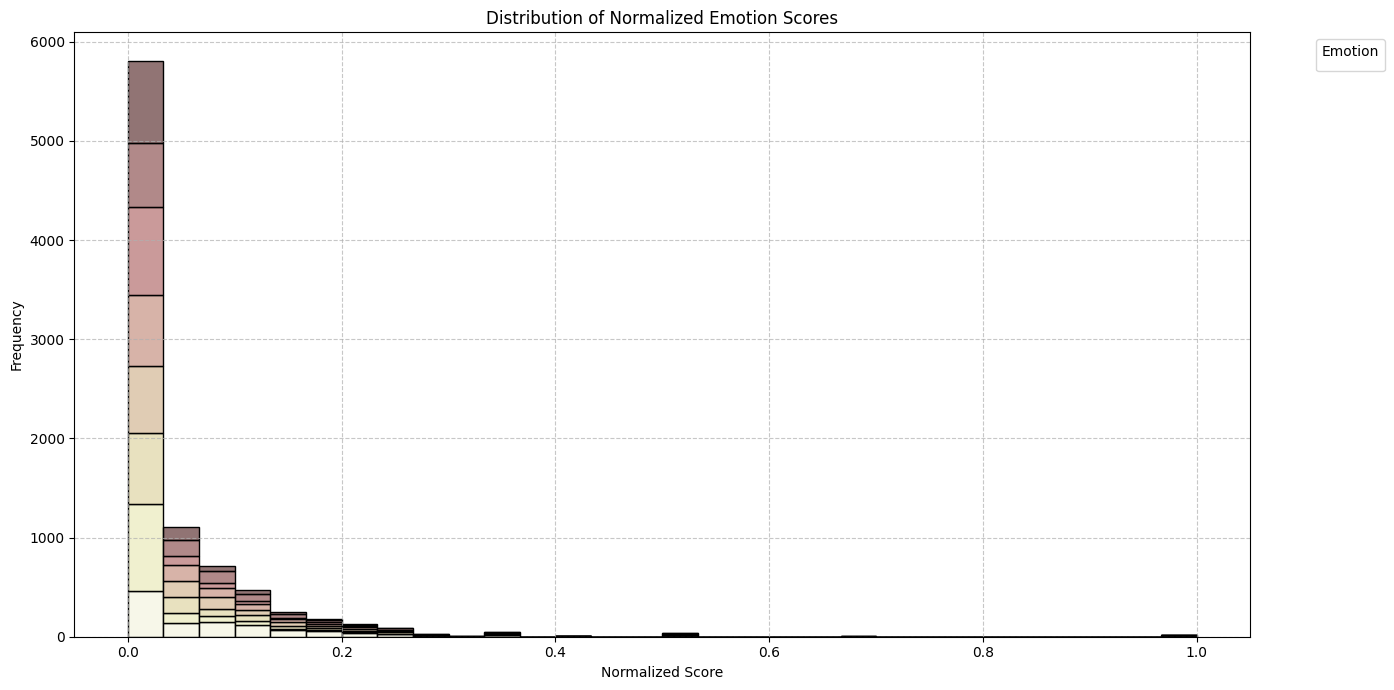

In [99]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert the DataFrame to long format for easier plotting
normalized_emotion_columns = [col for col in result_df.columns if col.startswith('normalised_')]
long_normalized_df = result_df.melt(id_vars=['Text', 'nb_tokens'], 
                                    value_vars=normalized_emotion_columns,
                                    var_name='Emotion',
                                    value_name='Score')

plt.figure(figsize=(14, 7))
sns.histplot(data=long_normalized_df, x='Score', hue='Emotion', multiple='stack', palette='pink', bins=30, kde=False)
plt.title('Distribution of Normalized Emotion Scores')
plt.xlabel('Normalized Score')
plt.ylabel('Frequency')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(title='Emotion', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


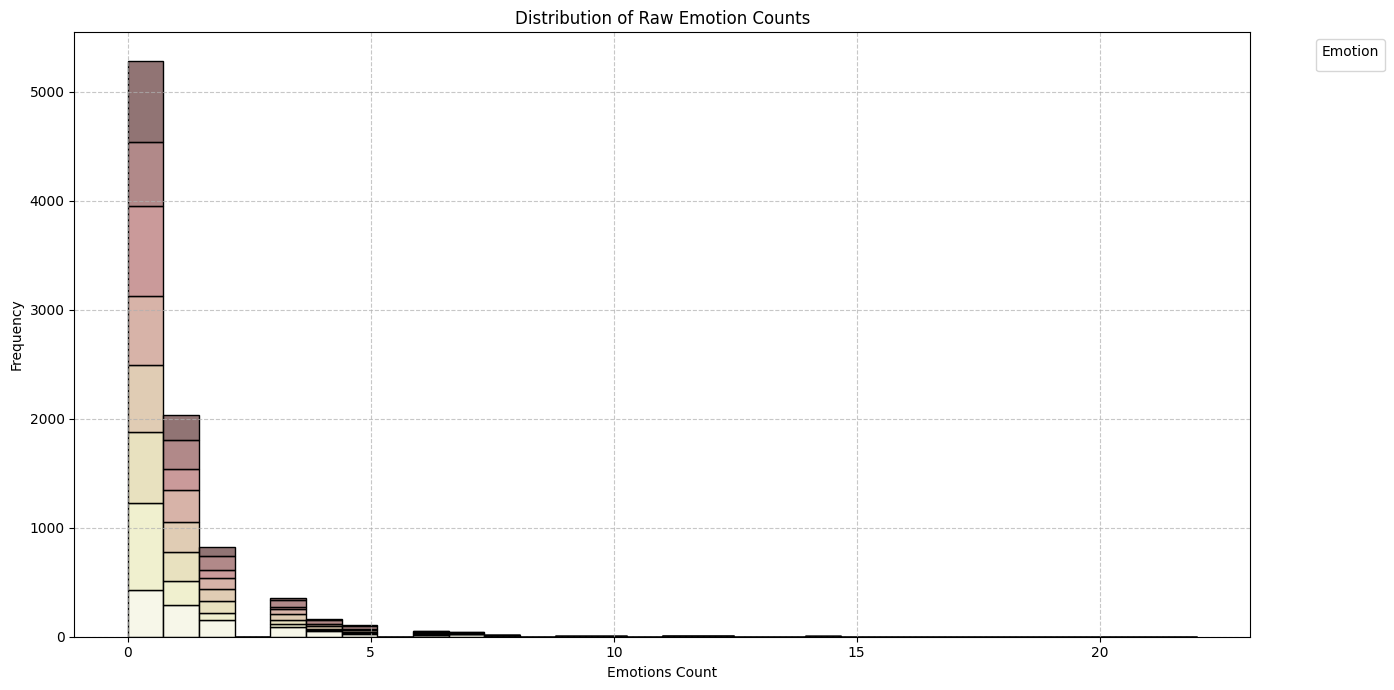

In [101]:
raw_emotion_columns = [col for col in result_df.columns if col.startswith('anger') or col.startswith('anticipation') or col.startswith('disgust') or col.startswith('fear') or col.startswith('joy') or col.startswith('sadness') or col.startswith('surprise') or col.startswith('trust')]
long_raw_df = result_df.melt(id_vars=['Text', 'nb_tokens'], 
                             value_vars=raw_emotion_columns,
                             var_name='Emotion',
                             value_name='Count')

plt.figure(figsize=(14, 7))
sns.histplot(data=long_raw_df, x='Count', hue='Emotion', multiple='stack', palette='pink', bins=30, kde=False)
plt.title('Distribution of Raw Emotion Counts')
plt.xlabel('Emotions Count')
plt.ylabel('Frequency')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(title='Emotion', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout() 
plt.show()


## Polarity Detection

In [72]:
nrc_lexicon = pd.read_csv(nrc_lexicon_path, sep='\t', header=None, names=['word', 'emotion', 'association'])

# Get pos and neg words
positive_words = nrc_lexicon[(nrc_lexicon['emotion'] == 'positive') & (nrc_lexicon['association'] == 1)]['word'].tolist()
negative_words = nrc_lexicon[(nrc_lexicon['emotion'] == 'negative') & (nrc_lexicon['association'] == 1)]['word'].tolist()

def count_polarity_words(text, positive_words, negative_words):
    words = text.split()
    pos_count = sum(1 for word in words if word in positive_words)
    neg_count = sum(1 for word in words if word in negative_words)
    return pos_count, neg_count

def normalise(pos_count, neg_count, nb_tokens):
    if nb_tokens == 0:
        return 0, 0 
    return pos_count / nb_tokens, neg_count / nb_tokens


### Normalise Polarity

In [73]:

processed_data[['positive_count', 'negative_count']] = processed_data['Text'].apply(
    lambda x: pd.Series(count_polarity_words(x, positive_words, negative_words)))

# nb of tokens for every text
processed_data['nb_tokens'] = processed_data['tokens'].apply(len)

processed_data[['normalised_positive', 'normalised_negative']] = processed_data.apply(
    lambda row: pd.Series(normalise(row['positive_count'], row['negative_count'], row['nb_tokens'])), axis=1)


In [91]:
print(processed_data['normalised_positive'])

0       0.050000
1       0.000000
2       0.071429
3       0.000000
4       0.000000
          ...   
5068    0.000000
5069    0.203704
5070    0.400000
5071    0.105263
5072    0.062500
Name: normalised_positive, Length: 1114, dtype: float64


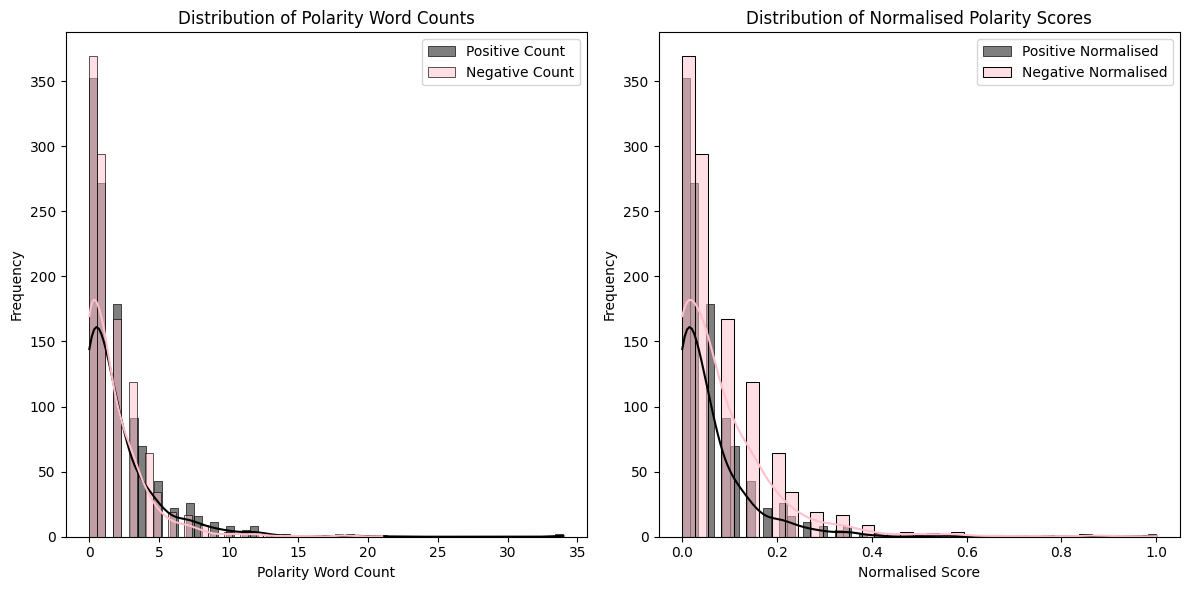

In [90]:
# Distribution of count
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(processed_data['positive_count'], kde=True, color='black', label='Positive Count')
sns.histplot(processed_data['negative_count'], kde=True, color='pink', label='Negative Count')
plt.title('Distribution of Polarity Word Counts')
plt.xlabel('Polarity Word Count')
plt.ylabel('Frequency')
plt.legend()

# Distribution of normalised score
plt.subplot(1, 2, 2)
sns.histplot(processed_data['positive_normalised'], kde=True, color='black', label='Positive Normalised')
sns.histplot(processed_data['negative_normalised'], kde=True, color='pink', label='Negative Normalised')
plt.title('Distribution of Normalised Polarity Scores')
plt.xlabel('Normalised Score')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()